In [1]:
#import pandas_profiling as pp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
#plt.style.use('default')

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

from sklearn.feature_selection import chi2, SelectKBest, VarianceThreshold

from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, recall_score, plot_confusion_matrix

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
import eli5
import shap
pd.set_option('display.max_rows', 250)
pd.set_option('display.min_rows', 100)
pd.set_option('display.max_columns', 30)

In [2]:
df = pd.read_csv('df_for_preprocessing_ord.csv')

In [3]:
df.shape

(14999, 24)

In [4]:
df.head()

id  satisfaction_level  last_evaluation  number_project  \
0   0                0.38             0.53               2   
1   1                0.80             0.86               5   
2   2                0.11             0.88               7   
3   3                0.72             0.87               5   
4   4                0.37             0.52               2   

   average_montly_hours  time_spend_company  Work_accident  churn  \
0                   157                   3              0      1   
1                   262                   6              0      1   
2                   272                   4              0      1   
3                   223                   5              0      1   
4                   159                   3              0      1   

   promotion_last_5years   dept  salary  sat_level_cluster  last_eval_cluster  \
0                      0  sales     0.0                1.0                0.0   
1                      0  sales     1.0                3.0                3.0   
2                      0  sales     1.0                0.0                3.0   
3                      0  sales     0.0                2.0                3.0   
4                      0  sales     0.0                1.0                0.0   

   avg_month_hr_cluster  satisfaction_level^1xlast_evaluation^1  \
0                   0.0                                  0.2014   
1                   2.0                                  0.6880   
2                   2.0                                  0.0968   
3                   1.0                                  0.6264   
4                   0.0                                  0.1924   

   satisfaction_level^1xnumber_project^1  \
0                                   0.76   
1                                   4.00   
2                                   0.77   
3                                   3.60   
4                                   0.74   

   satisfaction_level^1xaverage_montly_hours^1  \
0                                        59.66   
1                                       209.60   
2                                        29.92   
3                                       160.56   
4                                        58.83   

   satisfaction_level^1xtime_spend_company^1  \
0                                       1.14   
1                                       4.80   
2                                       0.44   
3                                       3.60   
4                                       1.11   

   last_evaluation^1xnumber_project^1  \
0                                1.06   
1                                4.30   
2                                6.16   
3                                4.35   
4                                1.04   

   last_evaluation^1xaverage_montly_hours^1  \
0                                     83.21   
1                                    225.32   
2                                    239.36   
3                                    194.01   
4                                     82.68   

   last_evaluation^1xtime_spend_company^1  \
0                                    1.59   
1                                    5.16   
2                                    3.52   
3                                    4.35   
4                                    1.56   

   number_project^1xaverage_montly_hours^1  \
0                                    314.0   
1                                   1310.0   
2                                   1904.0   
3                                   1115.0   
4                                    318.0   

   number_project^1xtime_spend_company^1  \
0                                    6.0   
1                                   30.0   
2                                   28.0   
3                                   25.0   
4                                    6.0   

   average_montly_hours^1xtime_spend_company^1  
0                                        471.0  
1                            

In [5]:
df.columns

Index(['id', 'satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'churn',
       'promotion_last_5years', 'dept', 'salary', 'sat_level_cluster',
       'last_eval_cluster', 'avg_month_hr_cluster',
       'satisfaction_level^1xlast_evaluation^1',
       'satisfaction_level^1xnumber_project^1',
       'satisfaction_level^1xaverage_montly_hours^1',
       'satisfaction_level^1xtime_spend_company^1',
       'last_evaluation^1xnumber_project^1',
       'last_evaluation^1xaverage_montly_hours^1',
       'last_evaluation^1xtime_spend_company^1',
       'number_project^1xaverage_montly_hours^1',
       'number_project^1xtime_spend_company^1',
       'average_montly_hours^1xtime_spend_company^1'],
      dtype='object')

In [6]:
#https://towardsdatascience.com/7-data-types-a-better-way-to-think-about-data-types-for-machine-learning-939fae99a689

#For personal purposes

useless_var = ['id']

nominal_var = ['dept']

ordinal_var = ['salary',
               'sat_level_cluster',
               'last_eval_cluster',
               'avg_month_hr_cluster']

binary_var = ['Work_accident',
              'promotion_last_5years']

target_var = ['churn']

count_var = ['number_project'
             #'time_spend_company']
            ]

interval_var = ['satisfaction_level',
                'last_evaluation',
                'average_montly_hours',
                #'satisfaction_level^1xlast_evaluation^1',
                'satisfaction_level^1xnumber_project^1',
                'satisfaction_level^1xaverage_montly_hours^1'
                #'satisfaction_level^1xtime_spend_company^1',
                #'last_evaluation^1xnumber_project^1',
                #'last_evaluation^1xaverage_montly_hours^1',
                #'last_evaluation^1xtime_spend_company^1',
                #'number_project^1xaverage_montly_hours^1',
                #'number_project^1xtime_spend_company^1',
                #'average_montly_hours^1xtime_spend_company^1']
               ]

num_var = count_var + interval_var
cat_var = nominal_var + ordinal_var + binary_var

## Transform the data

In [7]:
nominal_transformer = OneHotEncoder([['sales', 'accounting', 'hr', 'technical', 'support', 'management',
                                      'IT', 'product_mng', 'marketing', 'RandD']
                                    ])

num_transformer = MinMaxScaler()

In [8]:
preprocessor = ColumnTransformer(transformers = [
                                                ('scaler', num_transformer, num_var),
                                                ('onehot', nominal_transformer, nominal_var)
                                                ],
                                remainder = 'passthrough')

In [9]:
# Assign variables
X = df[num_var + cat_var]
y = df[target_var]

# Then split the remaining into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size = 0.3,
                                                    random_state = 42)

In [10]:
X_train.head()

number_project  satisfaction_level  last_evaluation  \
12602               7                0.10             0.84   
4889                4                0.57             0.68   
1572                2                0.39             0.48   
13375               4                0.91             0.68   
879                 5                0.82             0.97   

       average_montly_hours  satisfaction_level^1xnumber_project^1  \
12602                   250                                   0.70   
4889                    154                                   2.28   
1572                    154                                   0.78   
13375                   132                                   3.64   
879                     263                                   4.10   

       satisfaction_level^1xaverage_montly_hours^1         dept  salary  \
12602                                        25.00  product_mng     0.0   
4889                                         87.78   management     1.0   
1572                                         60.06    technical     0.0   
13375                                       120.12           IT     1.0   
879                                         215.66    technical     1.0   

       sat_level_cluster  last_eval_cluster  avg_month_hr_cluster  \
12602                0.0                2.0                   2.0   
4889                 2.0                1.0                   0.0   
1572                 1.0                0.0                   0.0   
13375                3.0                1.0                   0.0   
879                  3.0                3.0                   2.0   

       Work_accident  promotion_last_5years  
12602              0                      0  
4889               1                      0  
1572               0                      0  
13375              0                      0  
879                0                      0

In [11]:
# Fitting the preprocessor
X_train_transformed = preprocessor.fit_transform(X_train)

# Transform the input validation and test sets
X_test_transformed = preprocessor.transform(X_test)

In [12]:
# why we name the transformers
preprocessor.named_transformers_.keys()

dict_keys(['scaler', 'onehot', 'remainder'])

## Put all the transformed X data back into a dataframe

In [13]:
preprocessor.named_transformers_

{'scaler': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'onehot': OneHotEncoder(categories=[['sales', 'accounting', 'hr', 'technical', 'support',
                            'management', 'IT', 'product_mng', 'marketing',
                            'RandD']],
               drop=None, dtype=<class 'numpy.float64'>, handle_unknown='error',
               sparse=True),
 'remainder': 'passthrough'}

In [14]:
#Grab the column names for all of our nominal variables
one_hot_columns = preprocessor.named_transformers_.onehot.get_feature_names()

In [15]:
transformed_columns = num_var + list(one_hot_columns) + ordinal_var+ binary_var

In [16]:
len(transformed_columns)

22

In [17]:
X_train_transformed.shape # Great! They match

(10499, 22)

In [18]:
X_train_transform_df = pd.DataFrame(X_train_transformed, columns = transformed_columns)
X_test_transform_df = pd.DataFrame(X_test_transformed, columns = transformed_columns)

In [19]:
X_train_transform_df.columns

Index(['number_project', 'satisfaction_level', 'last_evaluation',
       'average_montly_hours', 'satisfaction_level^1xnumber_project^1',
       'satisfaction_level^1xaverage_montly_hours^1', 'x0_sales',
       'x0_accounting', 'x0_hr', 'x0_technical', 'x0_support', 'x0_management',
       'x0_IT', 'x0_product_mng', 'x0_marketing', 'x0_RandD', 'salary',
       'sat_level_cluster', 'last_eval_cluster', 'avg_month_hr_cluster',
       'Work_accident', 'promotion_last_5years'],
      dtype='object')

In [20]:
# Let's drop some of the features from our feature_eng notebook

X_train_feat_eng = X_train_transform_df.drop(columns=['x0_sales', 'x0_accounting', 'x0_support','x0_IT', 'x0_product_mng', 'x0_marketing'])

X_test_feat_eng = X_test_transform_df.drop(columns=['x0_sales', 'x0_accounting', 'x0_support','x0_IT', 'x0_product_mng', 'x0_marketing'])

In [21]:
classifiers = [
    LogisticRegression(penalty = 'l1', solver='saga', class_weight='balanced',random_state=42, C=1),
    #SVC(kernel="rbf", C=0.025, random_state=42, probability=True, class_weight='balanced'),
    DecisionTreeClassifier(class_weight='balanced', random_state=42),
    DecisionTreeRegressor(random_state=42),
    #VotingClassifier(random_state=42),
    RandomForestClassifier(class_weight='balanced', random_state=42),
    AdaBoostClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    xgb.XGBClassifier(scale_pos_weight=3.2,verbosity=0,random_state=42),
    CatBoostClassifier(class_weights=[1,3.2],verbose=False,random_seed=42)
    ]

for classifier in classifiers:
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(X_train_feat_eng, y_train)
    print(f'*****{classifier}*****')
    #print(classification_report(y_train,pipe.predict(X_train_transform_df)))
    print(classification_report(y_test,pipe.predict(X_test_feat_eng)))

*****LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)*****
              precision    recall  f1-score   support

           0       0.93      0.74      0.82      3428
           1       0.50      0.81      0.62      1072

    accuracy                           0.76      4500
   macro avg       0.71      0.78      0.72      4500
weighted avg       0.82      0.76      0.77      4500

*****DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weigh

In this case, we want to minimize the number of FN (Employees who are incorrectly predicted to not churn; they were actually supposed to churn), so we want a better recall score. Therefore, for our purposes, CatBoost performed the best.

For this case, we didn't set the `cat_features` for CatBoost. Will implement in future works.

## Model Tuning

In [24]:
model_cb = CatBoostClassifier(class_weights=[1,3.2],random_seed=42, verbose=False)

In [25]:
# model_cb.fit(X_train_feat_eng, y_train)

In [26]:
cat_columns = ['salary',
               'sat_level_cluster',
               'last_eval_cluster',
               'avg_month_hr_cluster',
               'Work_accident',
               'promotion_last_5years']

In [27]:
X_train_feat_eng_int = X_train_feat_eng.copy()
X_test_feat_eng_int = X_test_feat_eng.copy()

# Converting the categorical variables to integer so they can be considered as cat_features
X_train_feat_eng_int[cat_columns] = X_train_feat_eng[cat_columns].astype(int)
X_test_feat_eng_int[cat_columns] = X_test_feat_eng[cat_columns].astype(int)

In [28]:
train_pool = Pool(X_train_feat_eng_int,
                  y_train,
                  cat_features=cat_columns)

test_pool = Pool(X_test_feat_eng_int,
                 y_test,
                 cat_features=cat_columns)

In [27]:
model_cb.fit(train_pool,
             eval_set=test_pool,
             logging_level = 'Verbose',
             plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.056641

bestTest = 0.1381548769
bestIteration = 899

Shrink model to first 900 iterations.


In [28]:
print(classification_report(y_test,model_cb.predict(X_test_feat_eng_int)))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      3428
           1       0.92      0.94      0.93      1072

    accuracy                           0.97      4500
   macro avg       0.95      0.96      0.95      4500
weighted avg       0.97      0.97      0.97      4500



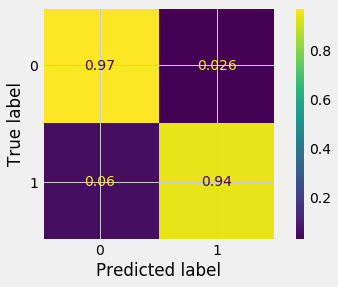

In [29]:
plot_confusion_matrix(model_cb, X_test_feat_eng_int, y_test, normalize='true')

Pretty good already, let's see if we can do slightly better.

## Random Grid Search

Random Grid search cv is good if you don't know where to start your grid search. You can list a bunch of combinations that you're interested in, and only randomly select a few to fit.

This will help you find a more selected number of hyperparameter to use in the normal grid search.

In [46]:
rand_grid = {
    'max_depth' : [6,7,8,9,10], 
    'n_estimators' : [100,250,500,1000],
    'subsample' : [0.5,0.6,0.7,0.8,0.9,1.0],
    'colsample_bylevel' : [0.5,0.6,0.7,0.8,0.9,1.0],
    'reg_lambda' : [1,3,5,10,20,50,100]
    }

In [47]:
cb_rand_cv = RandomizedSearchCV(estimator = model_cb,
                                 param_distributions = rand_grid,
                                 n_iter = 5,
                                 cv = 5,
                                 verbose = 2,
                                 random_state = 42,
                                 scoring = 'recall',
                                 n_jobs = -1)

In [48]:
cb_rand_cv.fit(X_train_feat_eng_int,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] subsample=0.7, reg_lambda=10, n_estimators=100, max_depth=6, colsample_bylevel=0.6 


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.7, reg_lambda=10, n_estimators=100, max_depth=6, colsample_bylevel=0.6, total=   0.6s
[CV] subsample=0.7, reg_lambda=10, n_estimators=100, max_depth=6, colsample_bylevel=0.6 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  subsample=0.7, reg_lambda=10, n_estimators=100, max_depth=6, colsample_bylevel=0.6, total=   0.5s
[CV] subsample=0.7, reg_lambda=10, n_estimators=100, max_depth=6, colsample_bylevel=0.6 
[CV]  subsample=0.7, reg_lambda=10, n_estimators=100, max_depth=6, colsample_bylevel=0.6, total=   0.4s
[CV] subsample=0.7, reg_lambda=10, n_estimators=100, max_depth=6, colsample_bylevel=0.6 
[CV]  subsample=0.7, reg_lambda=10, n_estimators=100, max_depth=6, colsample_bylevel=0.6, total=   0.4s
[CV] subsample=0.7, reg_lambda=10, n_estimators=100, max_depth=6, colsample_bylevel=0.6 
[CV]  subsample=0.7, reg_lambda=10, n_estimators=100, max_depth=6, colsample_bylevel=0.6, total=   0.6s
[CV] subsample=0.9, reg_lambda=50, n_estimators=250, max_depth=8, colsample_bylevel=0.9 
[CV]  subsample=0.9, reg_lambda=50, n_estimators=250, max_depth=8, colsample_bylevel=0.9, total=   2.2s
[CV] subsample=0.9, reg_lambda=50, n_estimators=250, max_depth=8, colsample_bylevel=0.9 
[CV]  subsample=0.9, reg_lambda=50,

[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.2min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7fb67c9f9860>,
                   iid='deprecated', n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bylevel': [0.5, 0.6, 0.7,
                                                              0.8, 0.9, 1.0],
                                        'max_depth': [6, 7, 8, 9, 10],
                                        'n_estimators': [100, 250, 500, 1000],
                                        'reg_lambda': [1, 3, 5, 10, 20, 50,
                                                       100],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1.0]},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring='recall', verbose=2)

In [35]:
cb_rand_cv.best_score_

0.951580761523046

In [50]:
cb_rand_cv.best_params_

{'subsample': 0.9,
 'reg_lambda': 1,
 'n_estimators': 1000,
 'max_depth': 8,
 'colsample_bylevel': 0.5}

In [51]:
cv_mean = cb_rand_cv.cv_results_['mean_test_score']
cv_std = cb_rand_cv.cv_results_['std_test_score']
cv_params_results = cb_rand_cv.cv_results_['params']

for mean, std, params in zip(cv_mean, cv_std, cv_params_results):
  print(f'{mean:0.3f} +/- {std:0.3f} for {params}')

0.915 +/- 0.009 for {'subsample': 0.7, 'reg_lambda': 10, 'n_estimators': 100, 'max_depth': 6, 'colsample_bylevel': 0.6}
0.924 +/- 0.008 for {'subsample': 0.9, 'reg_lambda': 50, 'n_estimators': 250, 'max_depth': 8, 'colsample_bylevel': 0.9}
0.927 +/- 0.009 for {'subsample': 0.7, 'reg_lambda': 20, 'n_estimators': 250, 'max_depth': 9, 'colsample_bylevel': 0.8}
0.952 +/- 0.008 for {'subsample': 0.9, 'reg_lambda': 1, 'n_estimators': 1000, 'max_depth': 8, 'colsample_bylevel': 0.5}
0.928 +/- 0.011 for {'subsample': 0.9, 'reg_lambda': 5, 'n_estimators': 250, 'max_depth': 7, 'colsample_bylevel': 1.0}


In [52]:
model_cb_2 = cb_rand_cv.best_estimator_

In [53]:
model_cb_2.fit(train_pool,
             eval_set=test_pool,
             logging_level = 'Verbose',
             plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.1393352422
bestIteration = 723

Shrink model to first 724 iterations.


In [54]:
print(classification_report(y_test,model_cb.predict(X_test_feat_eng_int)))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      3428
           1       0.92      0.94      0.93      1072

    accuracy                           0.97      4500
   macro avg       0.95      0.96      0.95      4500
weighted avg       0.97      0.97      0.97      4500



In [55]:
print(classification_report(y_test,model_cb_2.predict(X_test_feat_eng_int)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3428
           1       0.92      0.94      0.93      1072

    accuracy                           0.97      4500
   macro avg       0.95      0.96      0.96      4500
weighted avg       0.97      0.97      0.97      4500



### Can we further optimize with GridSearchCV?

In [65]:
param_grid = {
    'max_depth' : [8,9], 
    'n_estimators' : [1000],
    'subsample' : [0.7,0.9],
    'colsample_bylevel' : [0.5,0.8],
    'reg_lambda' : [1]
    }
CV = GridSearchCV(model_cb, param_grid, cv=3, scoring = 'recall', n_jobs= -1)
                  
CV.fit(X_train_feat_eng_int, y_train)  

GridSearchCV(cv=3, error_score=nan,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fb67c9f9860>,
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bylevel': [0.5, 0.8], 'max_depth': [8, 9],
                         'n_estimators': [1000], 'reg_lambda': [1],
                         'subsample': [0.7, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=0)

Reduced number of parameters and `cv` to help with runtime.

In [66]:
print(CV.best_params_)    
print(CV.best_score_)

{'colsample_bylevel': 0.5, 'max_depth': 8, 'n_estimators': 1000, 'reg_lambda': 1, 'subsample': 0.7}
0.9419767907162866


With grid search, the only parameter that changed is subsample (from 0.7 to 0.9)

In [67]:
model_cb_3 = CV.best_estimator_

In [68]:
model_cb_3.fit(train_pool,
             eval_set=test_pool,
             logging_level = 'Verbose',
             plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.1416996505
bestIteration = 712

Shrink model to first 713 iterations.


In [69]:
print(classification_report(y_test,model_cb_3.predict(X_test_feat_eng_int)))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      3428
           1       0.91      0.94      0.93      1072

    accuracy                           0.96      4500
   macro avg       0.95      0.96      0.95      4500
weighted avg       0.97      0.96      0.97      4500



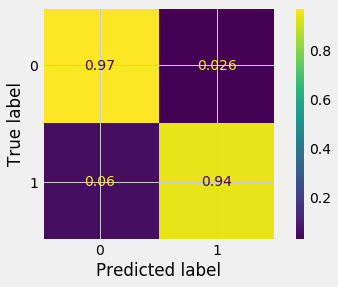

In [77]:
plot_confusion_matrix(model_cb, X_test_feat_eng_int, y_test, normalize='true')

In [22]:
model_cb_4 = CatBoostClassifier(class_weights=[1,3.2],
                                colsample_bylevel=0.5,
                                max_depth=8,
                                n_estimators=1000,
                                reg_lambda=1,
                                subsample=0.7,
                                early_stopping_rounds=10,
                                random_seed=42, 
                                verbose=False)

In [29]:
model_cb_4.fit(train_pool,
             eval_set=test_pool,
             logging_level = 'Verbose',
             plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.1432411087
bestIteration = 549

Shrink model to first 550 iterations.


In [30]:
print(classification_report(y_test,model_cb_4.predict(X_test_feat_eng_int)))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      3428
           1       0.91      0.94      0.92      1072

    accuracy                           0.96      4500
   macro avg       0.94      0.95      0.95      4500
weighted avg       0.96      0.96      0.96      4500



## Model Interpretation

In [31]:
eli5.show_weights(model_cb_4, feature_names=X_test_feat_eng_int.columns.to_list())

- How can we assess satisfaction level thru time?

In [32]:
shap.initjs()

In [33]:
model_cb_4.fit(X_train_feat_eng_int,y_train)

In [34]:
cb_explainer = shap.TreeExplainer(model_cb_4)
cb_shap_values = cb_explainer.shap_values(X_train_feat_eng_int)

In [35]:
# visualize the first prediction's explanation
shap.force_plot(cb_explainer.expected_value, cb_shap_values[0,:], X_train_feat_eng_int.iloc[0,:])

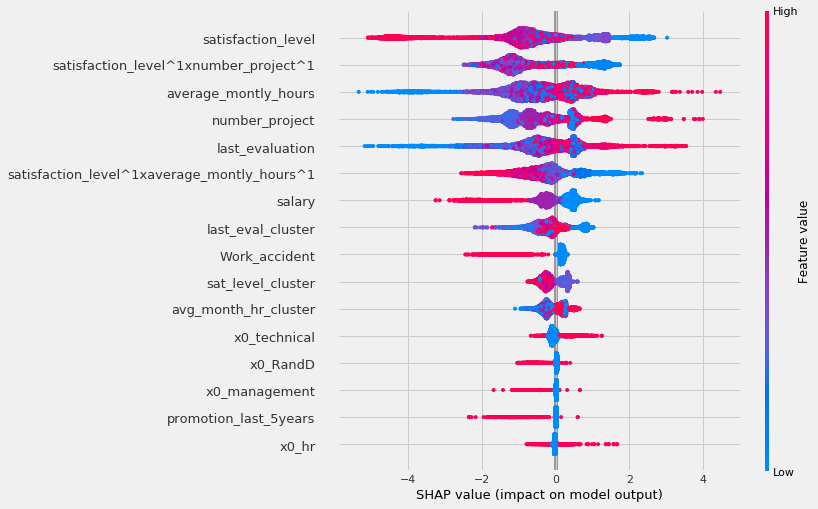

In [36]:
# visualize the training set predictions
shap.summary_plot(cb_shap_values, X_train_feat_eng_int)

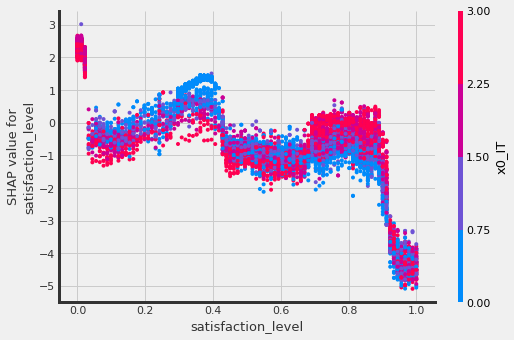

In [37]:
shap.dependence_plot('satisfaction_level', 
                     cb_shap_values, 
                     features = X_train_feat_eng_int,
                     feature_names = transformed_columns, 
                     #interaction_index = 'number_project'
                    )

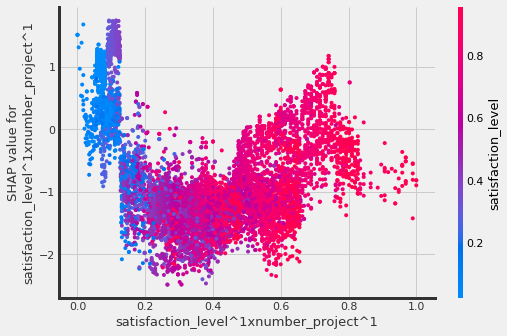

In [38]:
shap.dependence_plot('satisfaction_level^1xnumber_project^1', 
                     cb_shap_values, 
                     features = X_train_feat_eng_int,
                     feature_names = transformed_columns, 
                     interaction_index = 'satisfaction_level'
                    )

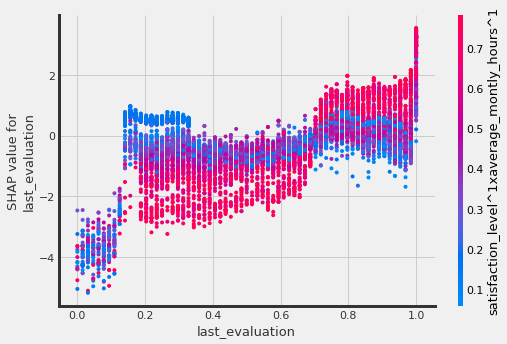

In [39]:
shap.dependence_plot('last_evaluation', 
                     cb_shap_values, 
                     features = X_train_feat_eng_int,
                     feature_names = transformed_columns, 
                     #interaction_index = 'satisfaction_level'
                    )

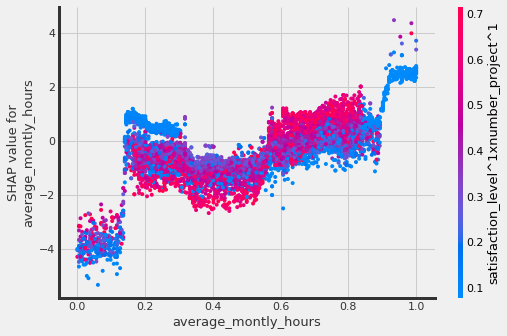

In [40]:
shap.dependence_plot('average_montly_hours', 
                     cb_shap_values, 
                     features = X_train_feat_eng_int,
                     feature_names = transformed_columns, 
                     #interaction_index = 'satisfaction_level'
                    )